In [1]:
#from transformers import AutoTokenizer, AutoModel
import sklearn
import pandas as pd
import json
import numpy as np
import ast
from tqdm.auto import tqdm
import statistics
import math

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load existing data

In [2]:
import csv
embedding_path = '../data/specter/df_embeddings.csv'
submission_path = '../data/database/outputs/df_prestige.csv'


df_embeddings = pd.read_csv(embedding_path)
df_embeddings = df_embeddings.T
df_embeddings.columns=df_embeddings.iloc[0]
df_embeddings = df_embeddings.iloc[1: , :]
#df_embeddings.to_csv('df_embeddings.csv', index = False)

tqdm.pandas()
def get_numpy (row):
  return ast.literal_eval(row.embedding)

df_embeddings['embedding'] = df_embeddings.progress_apply(lambda x: get_numpy(x), axis =1)

100%|██████████████████████████████████████| 2819/2819 [00:03<00:00, 774.62it/s]


In [3]:
df_embeddings.head()

Unnamed: 0,paper_id,embedding
S1VaB4cex,S1VaB4cex,"[0.08104710280895233, 0.5308438539505005, 0.08..."
H1W1UN9gg,H1W1UN9gg,"[0.07500883936882019, 0.5360254049301147, 0.04..."
r1GKzP5xx,r1GKzP5xx,"[0.11110689491033554, 1.2004060745239258, -0.0..."
S1J0E-71l,S1J0E-71l,"[-0.14411762356758118, 0.7905676364898682, 0.4..."
SJGCiw5gl,SJGCiw5gl,"[-0.26906102895736694, -0.11083536595106125, -..."


In [7]:
df_submissions = pd.read_csv(submission_path)
df_submission_labels = df_submissions[['id','title','conf_year','keywords','AVG_rating']]
df_submission_labels.head()

,id,title,conf_year,keywords,AVG_rating
0,B1-Hhnslg,Prototypical Networks for Few-shot Learning,2017,"[""Deep learning"", ""Transfer Learning""]",5.000000
1,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,2017,"[""Natural language processing"", ""Deep learning""]",6.333333
2,B12Js_yRb,Learning to Count Objects in Natural Images fo...,2018,"[""visual question answering"", ""vqa"", ""counting""]",5.333333
3,B13EC5u6W,Thinking like a machine — generating visual ra...,2018,"[""interpretability"", ""generative adversarial n...",6.333333
4,B13njo1R-,Progressive Reinforcement Learning with Distil...,2018,"[""Reinforcement Learning"", ""Distillation"", ""Tr...",6.333333


In [8]:
#break the embeddings into years

df_submission_labels[df_submission_labels['conf_year']==2017]

df_embeddings_2017 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2017], left_on='paper_id',right_on='id')
df_embeddings_2018 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2018], left_on='paper_id',right_on='id')
df_embeddings_2019 = df_embeddings.merge(df_submission_labels[df_submission_labels['conf_year']==2019], left_on='paper_id',right_on='id')

# Agglomerative Clustering of Anchor Group

In [65]:
#cluster only on the 2017  with cosine distance of 0.1

from sklearn.cluster import AgglomerativeClustering
x = np.array(df_embeddings_2017.embedding.tolist())
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, linkage="average", metric = 'cosine').fit(x)

df_embeddings_2017['agg_cluster'] = clustering.labels_.tolist()
df_embeddings_2017.shape

(484, 15)

In [66]:
#testing uncomment if necessary
#clustering.labels_
#unique_elements, counts_elements = np.unique(clustering.labels_, return_counts=True)
#print("Frequency of unique values of the said array:")
#print(np.asarray((unique_elements, counts_elements)))

In [67]:
#anchor group computing cluster centroid
from sklearn.neighbors import NearestCentroid
x = np.array(df_embeddings_2017.embedding.tolist())
y = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(x, y)
#clf.predict()
#print(clf.classes_)
#print(type((clf.centroids_)[1]))
#clf.predict(df_embeddings_2017[df_embeddings_2017['agg_cluster']==425].embedding.tolist())
#df_embeddings_2017[df_embeddings_2017['agg_cluster']==425] = clf.predict(x).tolist()
#df_embeddings_2017

NearestCentroid()

# Variable Ratio Matching with Agg Cluster and mimizing cosine distance

In [12]:
df_embeddings_2018.shape

(911, 7)

In [13]:
#https://stackoverflow.com/questions/62352209/how-to-get-11-corresponding-matches-using-sklearn-knearest-neighbors
#https://towardsdatascience.com/apply-propensity-score-method-in-causal-inference-part-2-k-nearest-neighbor-matching-c0cd2cdb0f74

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid

#setting up KNN for 2018
#note radius parameter doesnt do anything unless we use radius_neighbors
neigh = NearestNeighbors( n_neighbors=20, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)



#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
tuning_param_cos_dist = 0.3
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    #rng = neigh.radius_neighbors([clf.centroids_[cluster_id]])
    #break
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

In [14]:
#testing 
#dict_agg_cluster_matches[0][0].keywords

In [15]:
tqdm.pandas()

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.progress_apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')



100%|███████████████████████████████████████| 489/489 [00:00<00:00, 7444.97it/s]


In [16]:
#testing
#df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].head()
#df_embeddings_2017[['keywords_2018']]

In [17]:
#examples
first_row = df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','cos_dist_2018','keywords_2018']].iloc[0]

print(first_row.title,'|', first_row.keywords)
print('\n')

for title, keywords_2018, cos_dist_2018 in zip(first_row.titles_2018,first_row.keywords_2018, first_row.cos_dist_2018):
    print("title",title)
    print("Cosine Distance", cos_dist_2018)
    print("keywords:",keywords_2018)
#print(df_embeddings_2017[['title','keywords','agg_cluster','titles_2018','keywords_2018']].iloc[0].titles_2018)

FractalNet: Ultra-Deep Neural Networks without Residuals | []


title Building effective deep neural networks one feature at a time
Cosine Distance 0.10664268866456994
keywords: ["convolution neural networks", "architecture search", "meta-learning", "representational capacity"]
title Tandem Blocks in Deep Convolutional Neural Networks
Cosine Distance 0.11264963543577333
keywords: ["resnet", "residual", "shortcut", "convolutional", "linear", "skip", "highway"]
title Simple and efficient architecture search for Convolutional Neural Networks
Cosine Distance 0.11758314559444139
keywords: ["Deep Learning", "Hyperparameter Optimization", "Architecture Search", "Convolutional Neural Networks", "Network Morphism", "Network Transformation", "SGDR", "Cosine annealing", "hill climbing"]
title Learning Parsimonious Deep Feed-forward Networks
Cosine Distance 0.1181014457317826
keywords: ["Parsimonious Deep Feed-forward Networks", "structure learning", "classification", "overfitting", "fewer paramet

In [18]:
df_cos_dist_sample = pd.concat([df_embeddings_2017[['agg_cluster']],pd.DataFrame(df_embeddings_2017["cos_dist_2018"].to_list())], axis=1)

In [19]:
#df_cos_dist_sample

In [20]:
df_cos_dist_sample.describe()

,agg_cluster,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,...,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,189.165644,0.112675,0.125239,0.132694,0.137474,0.141772,0.145403,0.148193,0.150939,0.153556,...,0.157643,0.159651,0.161404,0.162903,0.164373,0.165774,0.167146,0.168497,0.169639,0.170821
std,131.383477,0.034663,0.034971,0.036010,0.036706,0.036859,0.037138,0.037483,0.037642,0.037856,...,0.038224,0.038399,0.038683,0.038789,0.038967,0.038879,0.038938,0.039069,0.039061,0.039112
min,0.000000,0.038121,0.049711,0.054592,0.055911,0.061101,0.062521,0.062599,0.063860,0.069776,...,0.072188,0.073851,0.075682,0.075743,0.076005,0.076906,0.076939,0.077324,0.077493,0.077600
25%,64.000000,0.087223,0.102626,0.110144,0.114808,0.119040,0.121060,0.124418,0.126802,0.128642,...,0.131871,0.133342,0.136130,0.138286,0.139231,0.141592,0.142659,0.144152,0.145471,0.146650
50%,182.000000,0.112097,0.124328,0.133216,0.137564,0.141847,0.145442,0.148981,0.151332,0.154025,...,0.157492,0.159481,0.160836,0.162526,0.164252,0.165322,0.167009,0.168537,0.169889,0.170389
75%,304.000000,0.135778,0.150388,0.157962,0.162016,0.166014,0.170113,0.172088,0.174825,0.179009,...,0.182547,0.184628,0.186686,0.188058,0.190271,0.192170,0.192758,0.195370,0.196522,0.197388
max,426.000000,0.234251,0.238361,0.250084,0.256839,0.265349,0.265853,0.269440,0.273905,0.274855,...,0.276463,0.277301,0.277636,0.278428,0.280493,0.281375,0.282682,0.288899,0.289486,0.290660


# Parameter Tuning (Old Dont use)

In [21]:
from scipy.special import gamma, factorial
#https://github.com/mick001/Control-Charts-Shiny
#https://www.uaar.edu.pk/fs/books/12.pdf check chapter 4.2 for reference
def get_c_4(n):
    #returns c4 constant    
    return math.sqrt(2/(n-1))*gamma(n/2)/gamma((n-1)/2)

def get_b4(n):
    #returns b4 constant
    return 1 + 3 * math.sqrt( 1 - get_c_4(n)**2 ) / get_c_4(n)

def get_a3(n):
    #returns a3 constant
    return 3 / (get_c_4(n) * math.sqrt(n)) 

def get_x_double_bar(df_spc):
    #returns x double bar with variable sample size
    x_double_bar = (df_spc.mean(axis=1) * df_spc.count(axis=1)).sum() / (df_spc.count(axis=1).sum())
    return x_double_bar

def get_s_bar(df_spc):
    #return s bar
    top = ((df_spc.count(axis =1) - 1) * df_spc.std(axis=1)**2 ).sum()
    bottom = df_spc.count(axis=1).sum() - df_spc.shape[0]

    return (top/bottom)**(0.5)
    
    
def spc_xbar(df_spc):
    #takes in a dataframe from tuning script and outputs number of samples out of control
    xdouble_bar = get_x_double_bar(df_spc)
    UCL_x_bar = xdouble_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
    out_control_count = UCL_x_bar < df_spc.mean(axis = 1)
    return out_control_count.sum()

def spc_sbar(df_spc):
    #takes in a dataframe from tuning script and outputs number of samples out of control
    return (df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc) < df_spc.std(axis = 1)).sum()

In [75]:
#tuning charts
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    match_number = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    if match_number == df_tuning.shape[0]:
        #input_row['full_sample_flag'] = 1
    #else:
        #input_row['full_sample_flag'] = 0
        
        df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
        df_spc['count'] = df_spc.count(axis=1)
        df_spc = df_spc[df_spc['count']>=2]
        df_spc = df_spc.drop(columns= ['count'])    
        if df_spc.shape[0] >=300:
            try:
                out_control_count_xbar = spc_xbar(df_spc)
                out_control_count_sbar = spc_sbar(df_spc)
                input_row['cosine_distance'] = tuning_param_cos_dist
                input_row['out_control_points_xbar'] = out_control_count_xbar
                input_row['out_control_points_sbar'] = out_control_count_sbar
                input_row['sample_size'] = df_spc.shape[0]

                data.append(input_row)

            except:
                continue
    else:
        continue
x = pd.DataFrame(data)     

In [70]:
x[x['sample_size']==489]

,cosine_distance,out_control_points_xbar,out_control_points_sbar,sample_size
13,0.238438,194,42,489
14,0.238739,194,42,489
15,0.239039,194,42,489
16,0.239339,192,42,489
17,0.239640,192,43,489
...,...,...,...,...
214,0.298799,183,45,489
215,0.299099,183,45,489
216,0.299399,183,45,489
217,0.299700,183,45,489


<AxesSubplot: title={'center': 'Tuning Sbar'}, xlabel='cosine_distance', ylabel='out_control_points_sbar'>

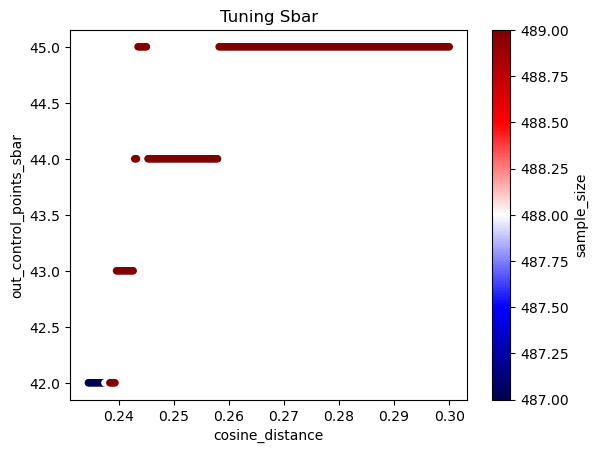

In [76]:
x.plot.scatter(x = 'cosine_distance', y='out_control_points_sbar', c='sample_size',colormap='seismic', title = "Tuning Sbar")

<AxesSubplot: title={'center': 'Tuning Xbar'}, xlabel='cosine_distance', ylabel='out_control_points_xbar'>

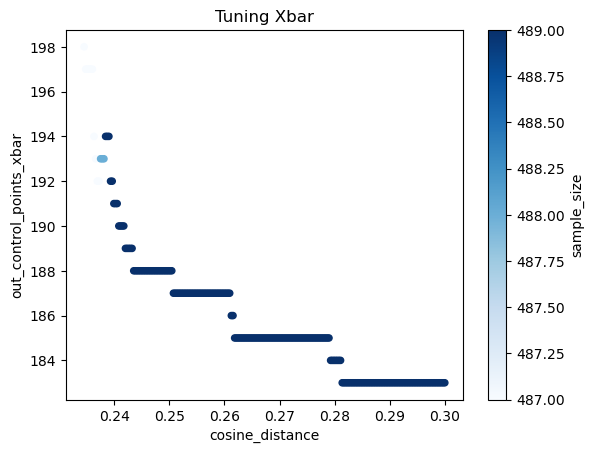

In [77]:
x.plot.scatter(x = 'cosine_distance', y='out_control_points_xbar', c ='sample_size',colormap='Blues', title = "Tuning Xbar")

(0.0, 0.275)

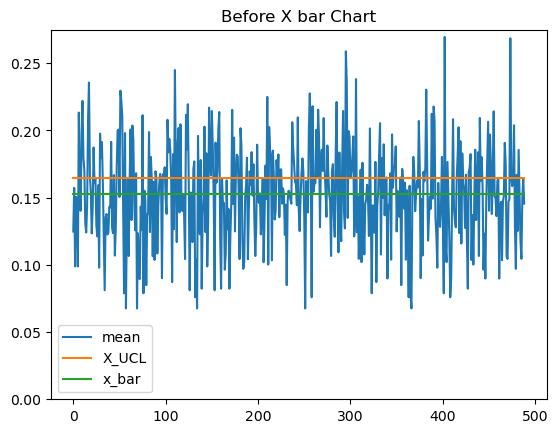

In [61]:
#http://www.bessegato.com.br/UFJF/resources/table_of_control_chart_constants_old.pdf
#given the reference table there
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"

tuning_param_cos_dist = 0.3
df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc['count'] = df_spc.count(axis=1)
df_spc = df_spc[df_spc['count']>=2]
df_spc = df_spc.drop(columns= ['count'])   
x_double_bar = get_x_double_bar(df_spc)
s_bar = get_s_bar(df_spc)

df_spc['X_UCL'] = x_double_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
df_spc['S_UCL'] = df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc)
df_spc['mean'] =df_tuning[df_tuning<=tuning_param_cos_dist].mean(axis=1)
df_spc['std'] = df_tuning[df_tuning<=tuning_param_cos_dist].std(axis=1)

df_spc['x_bar'] = pd.Series([x_double_bar for x in range(len(df_spc.index))])
df_spc['s_bar'] = pd.Series([s_bar for x in range(len(df_spc.index))])


df_spc[['mean','X_UCL','x_bar']].plot(title='Before X bar Chart').set_ylim(0,0.275)

#set_ylim(0,0.3)

(0.0, 0.05)

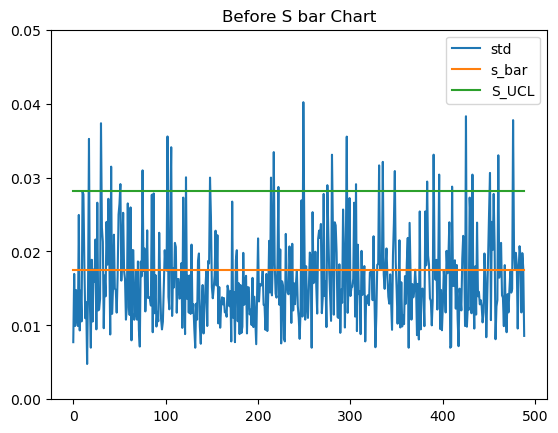

In [56]:
df_spc[['std','s_bar','S_UCL']].plot(title='Before S bar Chart').set_ylim(0,0.05)


(0.0, 0.275)

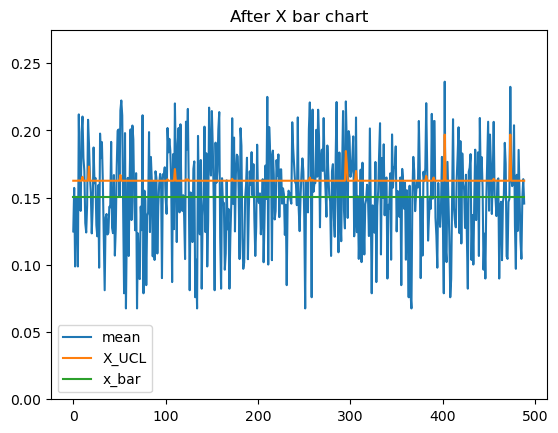

In [62]:
#http://www.bessegato.com.br/UFJF/resources/table_of_control_chart_constants_old.pdf
#given the reference table there
import matplotlib.pyplot as plt
#pd.options.plotting.backend = "plotly"

tuning_param_cos_dist = 0.238438
df_spc = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc['count'] = df_spc.count(axis=1)
df_spc = df_spc[df_spc['count']>=2]
df_spc = df_spc.drop(columns= ['count'])    
x_double_bar = get_x_double_bar(df_spc)
s_bar = get_s_bar(df_spc)

df_spc1 = df_tuning[df_tuning<=tuning_param_cos_dist]
df_spc1['count'] = df_spc1.count(axis=1)
df_spc1 = df_spc1[df_spc1['count']>=2]
df_spc1 = df_spc1.drop(columns= ['count'])   

df_spc['X_UCL'] = x_double_bar + df_spc.count(axis = 1).apply(lambda n: get_a3(n)) * get_s_bar(df_spc)
df_spc['S_UCL'] = df_spc.count(axis = 1).apply(lambda n: get_b4(n)) * get_s_bar(df_spc)

#Need to make sure that we do not include the count column, x_bar column, and s_bar colun but still main
# the average and standard deviation
df_spc['mean'] =df_spc1.mean(axis=1)
df_spc['std'] = df_spc1.std(axis=1)




df_spc=df_spc.reset_index()
df_spc['x_bar'] = pd.Series([x_double_bar for x in range(len(df_spc.index))])
df_spc['s_bar'] = pd.Series([s_bar for x in range(len(df_spc.index))])


df_spc[['mean','X_UCL','x_bar']].plot(title= "After X bar chart").set_ylim(0,0.275)

(0.0, 0.05)

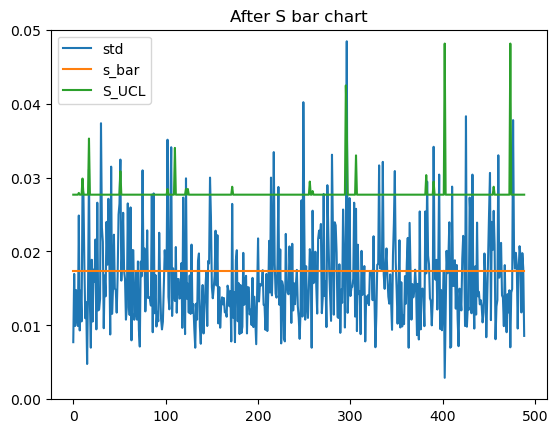

In [63]:
df_spc[['std','s_bar','S_UCL']].plot(title= "After S bar chart").set_ylim(0,0.05)


# Tuning Parameter Min Cosine with Max Samples

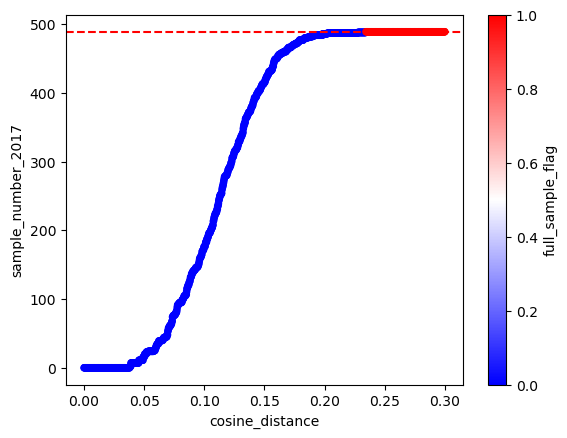

In [112]:
#tuning charts
#get the max number of samples with the lowest possible cosine distance
df_tuning = df_cos_dist_sample.drop(['agg_cluster'],axis = 1)

data = []
for tuning_param_cos_dist in np.linspace(0,0.3 ,1000):
    input_row = {}
    sample_number_from_2017 = df_tuning[df_tuning<=tuning_param_cos_dist].any(axis=1).sum()
    
    input_row['sample_number_2017'] = sample_number_from_2017
    input_row['cosine_distance'] = tuning_param_cos_dist
    if sample_number_from_2017 == df_tuning.shape[0]:
        input_row['full_sample_flag'] = 1
    else:
        input_row['full_sample_flag'] = 0
    data.append(input_row)


x = pd.DataFrame(data)   

fig = x.plot.scatter(x = 'cosine_distance', 
               y='sample_number_2017',
              c='full_sample_flag',
              colormap='bwr').axhline(df_tuning.shape[0], color="red", linestyle="dashed")
#fig.update_layout(coloraxis_showscale=False)

# Potential Outcome Model

In [74]:
tuning_param_knn = 10
#tuning_param_cos_dist = 0.238438
tuning_param_cos_dist = 0.3

neigh = NearestNeighbors( n_neighbors=tuning_param_knn, metric = 'cosine', radius = 0.3)
non_anchor_embedding_2018 = np.array(df_embeddings_2018.embedding.to_list())
neigh.fit(non_anchor_embedding_2018)

#setting up closest centroid for anchor group 2017
anchor_embedding_2017 = np.array(df_embeddings_2017.embedding.tolist())
anchor_agg_clusters_2017 = np.array(df_embeddings_2017.agg_cluster.tolist())
clf = NearestCentroid()
clf.fit(anchor_embedding_2017, anchor_agg_clusters_2017)


#dictionary of all the agg clusters and the 20 KNN from 2018
dict_agg_cluster_matches ={}
#tuning_param_cos_dist = 0.25
for cluster_id in np.unique(clustering.labels_):
    
    distances, indices = neigh.kneighbors([clf.centroids_[cluster_id]])
    df_anchor_embedding = pd.concat([pd.DataFrame(data = distances.T,columns =['cos_dist']),pd.DataFrame(indices.T,columns=['indices'])],axis=1)

    #get all the specified cosine distance 2018 papers
    #tuple of (dataframe of 2018 matched papers, cosine distances)
    dict_agg_cluster_matches[cluster_id] = (
        df_embeddings_2018.iloc[df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].indices.to_list(), :],
        df_anchor_embedding[df_anchor_embedding['cos_dist']<= tuning_param_cos_dist].cos_dist.to_list()
    )

tqdm.pandas()

def lambda_get_2018_matches(row):
    #get embedding matches from 2018 papers
    #returning relevant information
    df_clustered_papers = dict_agg_cluster_matches[row.agg_cluster]
    
    lst_paper_titles = df_clustered_papers[0].title.tolist()
    lst_paper_ids = df_clustered_papers[0].paper_id.tolist()
    ls_paper_keywords = df_clustered_papers[0].keywords.values.tolist()
    ls_cos_distances = df_clustered_papers[1]
    
    return lst_paper_titles, ls_paper_keywords, lst_paper_ids, ls_cos_distances
    
    
    

df_embeddings_2017[['titles_2018','keywords_2018','id_2018','cos_dist_2018']]= df_embeddings_2017.progress_apply(lambda x: lambda_get_2018_matches(x),axis=1, result_type ='expand')

def get_num_knn_matches(row):
    count = len(row.titles_2018)
    return(len(row.titles_2018))

df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.progress_apply(lambda x: get_num_knn_matches(x),axis =1)
df_embeddings_2017['num_knn_matches'].describe()

df_embeddings_2017.to_csv('../data/database/outputs/df_cluster_results.csv',index=False)

df_embeddings_2017.shape

100%|█████████████████████████████████████| 484/484 [00:00<00:00, 117167.44it/s]


(484, 15)

In [32]:
#Matching potential outcome estimator
#Keith et al. 2020
#https://aclanthology.org/2020.acl-main.474.pdf
#equation 7 and 8

def lambda_get_match_potential_outcomes(row):
    #equation 7 in the paper
    paper_ids = row.id_2018
    big_m = len(row.id_2018)
    if big_m == 0:
        return None
    ratings = [df_embeddings_2018[df_embeddings_2018['paper_id'] == paper_id].AVG_rating.values[0] for paper_id in paper_ids]
    return sum(ratings)/big_m
        
    

df_embeddings_2017['match_ave_rating'] = df_embeddings_2017.progress_apply(lambda row: lambda_get_match_potential_outcomes(row), axis =1)
df_embeddings_2017['diff_2018_2017'] = df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']

df_embeddings_2017 = df_embeddings_2017.loc[df_embeddings_2017['match_ave_rating'].notnull(),]

#equation 8 in the paper
SATE = (df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating']).sum()/df_embeddings_2017.shape[0]
#check that the 2 vectors are same size.

if df_embeddings_2017['match_ave_rating'].shape[0] == df_embeddings_2017['AVG_rating'].shape[0]:
    print('Passed check')
else:
    print('error')
STD = ((df_embeddings_2017['match_ave_rating'] - df_embeddings_2017['AVG_rating'])).std()
print('SATE:', SATE)
#print('STD:', STD)

100%|████████████████████████████████████████| 489/489 [00:00<00:00, 761.76it/s]

Passed check
SATE: -0.14262019546110452


# Bootstrapping

100%|███████████████████████████████████| 50000/50000 [00:06<00:00, 7820.28it/s]


Bootstrap ATE:  -0.14555138568688544
95% confidence interval:  -0.26955199077644243 -0.021685888686684796
range of CI:  0.24786610208975762


Text(0.5, 1.0, 'Check of Difference in Mean Distribution')

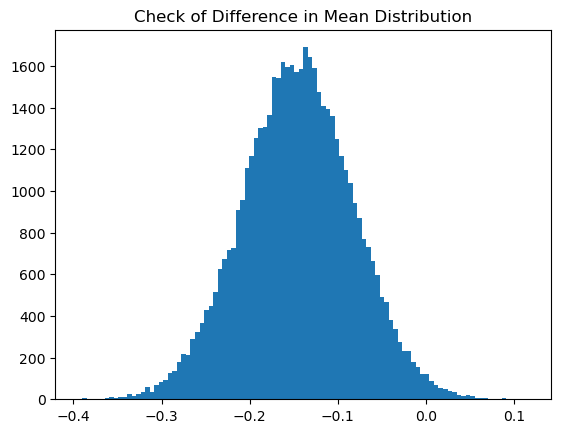

In [120]:
#https://egrcc.github.io/docs/math/all-of-statistics.pdf chapter 8.2
import statistics
bootstrap_std = []
bootstrap_mean = []
for n in tqdm(range(50000)):
    sample = df_embeddings_2017.diff_2018_2017.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    #bootstrap_std.append(sample.std())
    bootstrap_mean.append(sample.mean())
    

mean = statistics.mean(bootstrap_mean)


print("Bootstrap ATE: ", mean)

#statistics.stdev(bootstrap_mean)

print('95% confidence interval: ',np.quantile(bootstrap_mean, 0.025),np.quantile(bootstrap_mean, 0.975) )
print('range of CI: ',abs(np.quantile(bootstrap_mean, 0.025)) -abs(np.quantile(bootstrap_mean, 0.975)))
plt.hist(np.array(bootstrap_mean), 100)
plt.title('Check of Difference in Mean Distribution')

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3854.61it/s]


Bootstrap Naive ATE:  -0.2329992986507405
95% confidence interval:  -0.3777871405856553 -0.09097839769133412
range of CI:  0.28680874289432123


Text(0.5, 1.0, 'Check of Difference in Mean Distribution')

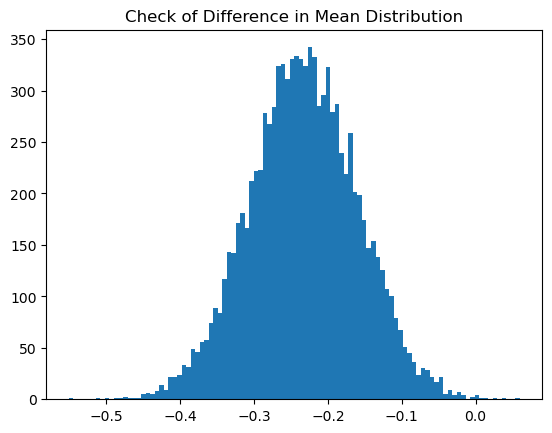

In [119]:
df_embeddings_2018

bootstrap_naive_mean = []

for n in tqdm(range(10000)):
    sample_2017 = df_embeddings_2017.AVG_rating.sample(n=df_embeddings_2017.shape[0], replace = True ,random_state=n)
    sample_2018 = df_embeddings_2018.AVG_rating.sample(n=df_embeddings_2018.shape[0], replace = True ,random_state=n)
    
    sample_diff = sample_2018.mean() - sample_2017.mean()
    
    bootstrap_naive_mean.append(sample_diff)

naive_mean = statistics.mean(bootstrap_naive_mean)


print("Bootstrap Naive ATE: ", naive_mean)
print('95% confidence interval: ',np.quantile(bootstrap_naive_mean, 0.025),np.quantile(bootstrap_naive_mean, 0.975) )
print('range of CI: ',abs(np.quantile(bootstrap_naive_mean, 0.025)) -abs(np.quantile(bootstrap_naive_mean, 0.975)))
plt.hist(np.array(bootstrap_naive_mean), 100)
plt.title('Check of Difference in Mean Distribution')

# Check for repeat

In [491]:
import itertools
#see how often a paper is matched
df_embeddings_2017.id_2018.to_list()

x = pd.DataFrame(list(itertools.chain.from_iterable(df_embeddings_2017.id_2018.to_list())),columns=['paper_id']).value_counts()

x.filter(like='Hk6kPgZA-', axis=0)


paper_id 
Hk6kPgZA-    6
dtype: int64

In [603]:
df_embeddings_2017['num_knn_matches'].describe()

count    489.000000
mean       9.924335
std        0.683830
min        2.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: num_knn_matches, dtype: float64

# Checking to see if there is 20 matches on each title

In [493]:
def get_num_knn_matches(row):
    count = len(row.titles_2018)
    return(len(row.titles_2018))

df_embeddings_2017['num_knn_matches'] = df_embeddings_2017.progress_apply(lambda x: get_num_knn_matches(x),axis =1)

df_embeddings_2017[df_embeddings_2017['num_knn_matches']<20]

100%|██████████████████████████| 340/340 [00:00<00:00, 30436.32it/s]


,paper_id,embedding,id,title,conf_year,keywords,AVG_rating,agg_cluster,titles_2018,keywords_2018,id_2018,cos_dist_2018,match_ave_rating,diff_2018_2017,num_knn_matches
9,Hkz6aNqle,"[0.06979002058506012, 1.0995328426361084, 0.01...",Hkz6aNqle,Deep Error-Correcting Output Codes,2017,[],3.000000,223,[DNN Representations as Codewords: Manipulatin...,"[[""DNN representation"", ""penalty regularizatio...",[rkQu4Wb0Z],[0.16541152600671638],5.000000,2.000000,1
11,B1hdzd5lg,"[-0.4731249511241913, 0.8286098837852478, 0.27...",B1hdzd5lg,Words or Characters? Fine-grained Gating for R...,2017,"[""Natural language processing"", ""Deep learning""]",6.666667,211,[Multi-Mention Learning for Reading Comprehens...,"[[""reading comprehension"", ""multi-loss"", ""ques...","[HyRnez-RW, HJRV1ZZAW, B14TlG-RW, B1bgpzZAZ, B...","[0.12481209380740332, 0.13436664053345482, 0.1...",5.238095,-1.428571,7
12,Bks8cPcxe,"[-0.47187483310699463, 1.1405317783355713, 0.1...",Bks8cPcxe,DeepDSL: A Compilation-based Domain-Specific L...,2017,"[""Deep learning"", ""Applications"", ""Optimization""]",7.000000,191,[DLVM: A modern compiler infrastructure for de...,"[[""deep learning"", ""automatic differentiation""...","[ryG6xZ-RZ, rkTBjG-AZ, HyKZyYlRZ, S1XolQbRW, r...","[0.09927690767401764, 0.160388476227592, 0.160...",6.102564,-0.897436,13
17,ryTYxh5ll,"[-0.8676003813743591, 1.589058756828308, 0.918...",ryTYxh5ll,CONTENT2VEC: SPECIALIZING JOINT REPRESENTATION...,2017,"[""Applications""]",3.666667,193,[THE EFFECTIVENESS OF A TWO-LAYER NEURAL NETWO...,"[[""Recommender systems"", ""deep learning"", ""per...","[B1lMMx1CW, ryY4RhkCZ]","[0.13772818024214628, 0.16903439383917118]",5.000000,1.333333,2
18,HJhcg6Fxg,"[-0.5211748480796814, 1.4965888261795044, 0.27...",HJhcg6Fxg,Binary Paragraph Vectors,2017,"[""Natural language processing"", ""Transfer Lear...",5.666667,280,"[Learning Document Embeddings With CNNs, Zero-...","[[""unsupervised embedding"", ""convolutional neu...","[ryHM_fbA-, S1XXq6lRW, SkJd_y-Cb, B1e5ef-C-, B...","[0.1312895269671257, 0.1507048058033218, 0.152...",5.561404,-0.105263,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,rJzaDdYxx,"[-0.05915672332048416, 0.5122181177139282, -0....",rJzaDdYxx,Gradients of Counterfactuals,2017,"[""Deep learning"", ""Computer vision"", ""Theory""]",3.666667,124,"[INTERPRETATION OF NEURAL NETWORK IS FRAGILE, ...","[[""Adversarial Attack"", ""Interpretability"", ""S...","[H1xJjlbAZ, rk6H0ZbRb, SJaP_-xAb, SyzKd1bCW, S...","[0.14499503183034523, 0.1526100541006532, 0.16...",5.650000,1.983333,10
476,Sy7m72Ogg,"[0.42904555797576904, 0.10486793518066406, 0.4...",Sy7m72Ogg,An Actor-critic Algorithm for Learning Rate Le...,2017,"[""Deep learning"", ""Reinforcement Learning""]",4.000000,45,"[Guide Actor-Critic for Continuous Control, So...","[[""Reinforcement learning"", ""actor-critic"", ""c...","[BJk59JZ0b, HJjvxl-Cb, BkUp6GZRW, SyzKd1bCW, S...","[0.08519698934115416, 0.09608976759580856, 0.1...",5.606061,1.606061,11
477,SJNDWNOlg,"[0.24190032482147217, 1.2690263986587524, -0.0...",SJNDWNOlg,What Is the Best Practice for CNNs Applied to ...,2017,"[""Computer vision"", ""Deep learning""]",4.000000,35,"[Simple Fast Convolutional Feature Learning, L...","[[""Feature Learning"", ""Convolutional Neural Ne...","[SyGT_6yCZ, Skvd-myR-]","[0.15154036738782817, 0.16475049535782305]",3.666667,-0.333333,2
480,SkXIrV9le,"[0.24463148415088654, 1.0909415483474731, 0.10...",SkXIrV9le,Perception Updating Networks: On architectural...,2017,"[""Structured prediction"", ""Unsupervised Learni...",4.000000,100,[Neural Networks for irregularly observed cont...,"[[""Deep Learning"", ""Stochastic Processes"", ""Ti...","[S1fHmlbCW, rk49Mg-CW, Sk7cHb-C-, HJIhGXWCZ, H...","[0.13204550248724745, 0.13273742091289975, 0.1...",5.160714,1.160714,14


# Save CSVs

In [494]:
df_embeddings_2017.to_csv('../data/database/outputs/df_cluster_results.csv',index=False)